In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
from scipy.ndimage import label, binary_fill_holes
from skimage.measure import perimeter

In [2]:
# packages needed for animation
from IPython.display import clear_output, display, HTML
from IPython.display import HTML
from matplotlib.colors import ListedColormap

In [29]:
# full prelim CPM (Hamiltonian with deltaH_area & deltaH_perimeter)

class CPM:
    def __init__(self, grid_size, num_cells, target_area, target_ratio, temperature, initialization):
        self.grid_size = grid_size
        self.num_cells = num_cells
        self.target_area = target_area
        self.target_ratio = target_ratio
        self.temperature = temperature
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.mc_time = 0
        self.gill_time = 0.0

        # initialize cells on grid (random, ideal, space_filling)
        if initialization == "random":
          self.initialize_cells_random()
        elif initialization == "ideal":
          self.initialize_cells_ideal()
        elif initialization == "space_filling":
          self.initialize_cells_space_filling()
        elif initialization == "voronoi":
          self.initialize_cells_voronoi()
        else:
          print("invalid initialization")

    # figure out a better (non-hard coded way) to create cell of approx. circular shape to start with

    #all initializations
    def initialize_cells_random(self): #choose cell centers randomly
        cell_ids = range(1, self.num_cells + 1)

        # new implementation: randomly choose cell centers, can totally overwrite previous cell if a cell center is
        # repeatedly chosen, code should still work but num_cells value may be lower than highest cell ID
        for cell_id in cell_ids:
            y, x = random.randint(3, self.grid_size - 4), random.randint(3, self.grid_size - 4)
            # main square
            self.grid[y-2:y+3, x-2:x+3] = cell_id #[inclusive, exclusive)
            #sides
            self.grid[y-1:y+2, x-3] = cell_id # left
            self.grid[y-3, x-1:x+2] = cell_id # top
            self.grid[y-1:y+2, x+3] = cell_id # right
            self.grid[y+3, x-1:x+2] = cell_id # bottom

        #get new number of cells
        existing_cell_ids = np.unique(self.grid)
        existing_cell_ids = existing_cell_ids[existing_cell_ids != 0]
        self.num_cells = len(existing_cell_ids)
        

        # old implementation: always places centers on whitespace but can get stuck in while loop if no whitespace left
        """
        for cell_id in cell_ids:
            while True:
                y, x = random.randint(3, self.grid_size - 4), random.randint(3, self.grid_size - 4)
                if self.grid[y, x] == 0:
                    # main square
                    self.grid[y-2:y+3, x-2:x+3] = cell_id #[inclusive, exclusive)
                    #sides
                    self.grid[y-1:y+2, x-3] = cell_id # left
                    self.grid[y-3, x-1:x+2] = cell_id # top
                    self.grid[y-1:y+2, x+3] = cell_id # right
                    self.grid[y+3, x-1:x+2] = cell_id # bottom
                    break
        """

    def initialize_cells_ideal(self): #choose cell centers such as to uniformly place cells across space
        cell_id = 1
        for y in range(3, self.grid_size - 3, 7):
            for x in range(3, self.grid_size - 3, 7):
                # main sqaure
                self.grid[y-2:y+3, x-2:x+3] = cell_id #[unclusive, exclusive]
                #sides
                self.grid[y-1:y+2, x-3] = cell_id # left
                self.grid[y-3, x-1:x+2] = cell_id # top
                self.grid[y-1:y+2, x+3] = cell_id # right
                self.grid[y+3, x-1:x+2] = cell_id # bottom

                cell_id += 1
    def initialize_cells_space_filling(self):
      self.initialize_cells_ideal() # build upon above, so cells are vaguely circular
      # iterate through all spaces, looking for empty ones
      while 0 in self.grid:
        for y in range(0, self.grid_size):
          for x in range(0, self.grid_size):
            #if empty
            if self.grid[y, x] == 0:
              new_cell_id = [0] # start empty lsit
              for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]: #look at IDs of all neighbors
                  nx, ny = (x + dx) , (y + dy)
                  if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size: #if neighbor has valid indices
                    if self.grid[ny, nx] != 0:
                      new_cell_id.append(self.grid[ny, nx])
              random_id = random.choice(new_cell_id) #choose new ID randomly
              self.grid[y, x] = random_id
    def initialize_cells_voronoi(self):

        center_method = "uniform"

        if center_method == "uniform": # Generate cell centers with uniform spacing
          # Calculate spacing for uniform distribution
          num_rows = int(np.sqrt(self.num_cells))
          num_cols = int(np.ceil(self.num_cells / num_rows))
          spacing_y = int(self.grid_size / num_rows)  # Spacing in y direction
          spacing_x = int(self.grid_size / num_cols)  # Spacing in x direction

          # calulcate centers
          cell_centers = []
          cell_id = 1  # Start cell ID from 1

          for i in range(num_rows):
              for j in range(num_cols):
                  y = spacing_y // 2 + i * spacing_y
                  x = spacing_x // 2 + j * spacing_x
                  cell_centers.append((y, x))
                  cell_id += 1
                  if cell_id > self.num_cells:
                      break  # Stop if we've reached the desired number of cells
              if cell_id > self.num_cells:
                  break

        if center_method == "random": #Randomly choose cell centers:
          cell_ids = range(1, self.num_cells + 1)
          cell_centers = []
          for cell_id in cell_ids:
              y, x = random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1) #random.randint [inclusive, inclusive]
              cell_centers.append((y, x))

        #Assign pixels to cell center
        for y in range(self.grid_size):
            for x in range(self.grid_size):
                min_dist = float('inf')
                closest_cell_id = 0
                for cell_id, (cy, cx) in enumerate(cell_centers, 1):  # Start cell_id from 1
                    dist = np.sqrt((y - cy)**2 + (x - cx)**2)
                    if dist < min_dist:
                        min_dist = dist
                        closest_cell_id = cell_id
                self.grid[y, x] = closest_cell_id

    # update to be skimage.measure.regionprops() perimeter
    def calculate_perimeter(self, cell_id):

        # skimage.measure.regionprops() perimeter
        binary_grid = (self.grid == cell_id)
        perimeter_value = perimeter(binary_grid, neighborhood = 8)

        return perimeter_value


    def calculate_hamiltonian(self):
        hamiltonian = 0
        for cell_id in range(1, np.max(self.grid) + 1):
          if np.sum(self.grid == cell_id) > 0:  # if cell exists
            # deltaH_ground: Check for disjoint parts
            labeled_array, num_features = label(self.grid == cell_id)
            if num_features > 1:
               return np.inf  # Negative infinity for disjoint parts

            # calc area & perimeter
            area = 0.25*np.sum(self.grid == cell_id)
            perimeter = self.calculate_perimeter(cell_id)

            # Energy terms for area and perimeter/area ratio
            hamiltonian += 0.2*np.abs(area - self.target_area) # deltaH_area
            hamiltonian += 0.8*(np.abs(((area**(1/2)) / perimeter) - self.target_ratio)) # deltaH_area/perimeter_ratio

        return hamiltonian


    def monte_carlo_step(self):
        for _ in range(self.grid_size**2):  # N random grid points
            i_x, i_y = random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)
            dx, dy = random.choice([(1, 0), (-1, 0), (0, 1), (0, -1)])
            j_x, j_y = (i_x + dx), (i_y + dy)

            # if jx,jy is a valid grid point (no wrapping around)
            if (0 <= j_x < self.grid_size) & (0 <= j_y < self.grid_size):
                #if xi,xj and jx,jy have different cell IDs
                if (self.grid[i_y, i_x] != self.grid[j_y, j_x]):

                  #old hamiltonian with old j ID
                  old_j_value = self.grid[j_y, j_x]
                  old_hamiltonian = self.calculate_hamiltonian()

                  # change j to i, calculate new hamiltonian
                  self.grid[j_y, j_x] = self.grid[i_y, i_x]
                  new_hamiltonian = self.calculate_hamiltonian()

                  # deltaH
                  delta_hamiltonian = new_hamiltonian - old_hamiltonian

                  if (delta_hamiltonian <= 0) or (random.random() < np.exp(-delta_hamiltonian / self.temperature)):
                      pass  # accept j -> i
                  else:
                      self.grid[j_y, j_x] = old_j_value  # reject j -> i
        self.mc_time += 1 #increment time by 1 every time one full monte carlo step is complete (all N events have been attempted)
    
    def gillespie_step(self):
        events = []
        rates = []

        # all possible copy events and their rates (probability of occuring)
        for i_y in range(self.grid_size):
            for i_x in range(self.grid_size):
                for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                    j_x, j_y = i_x + dx, i_y + dy
                    if 0 <= j_x < self.grid_size and 0 <= j_y < self.grid_size:
                        if self.grid[i_y, i_x] != self.grid[j_y, j_x]:
                            # calculate deltaH for this event
                            old_j_value = self.grid[j_y, j_x]
                            old_hamiltonian = self.calculate_hamiltonian()
                            self.grid[j_y, j_x] = self.grid[i_y, i_x]
                            new_hamiltonian = self.calculate_hamiltonian()
                            self.grid[j_y, j_x] = old_j_value  # revert

                            deltaH = new_hamiltonian - old_hamiltonian
                            # rate: exp(-deltaH/T) if deltaH > 0, else 1
                            if deltaH <= 0:
                                rate = 1.0
                            else:
                                rate = np.exp(-deltaH / self.temperature)
                            events.append(((i_x, i_y), (j_x, j_y)))
                            rates.append(rate)
        total_rate = np.sum(rates)
        if total_rate == 0:
            return  # no possible events

        # proportionally choose which event occurs
        chosen_index = np.random.choice(len(events), p=np.array(rates)/total_rate)
        (i_x, i_y), (j_x, j_y) = events[chosen_index]
        self.grid[j_y, j_x] = self.grid[i_y, i_x]

        # move forward in time, prbability of any event occuring (like aggregated poisson)
        U = np.random.uniform() #choose random number from uniform dist [0, 1)
        delta_t = -np.log(U) / total_rate # waiting time for next event is expential; adds up to poisson process over many events
        self.gill_time += delta_t
      

In [28]:
# create + animate ex. of above
# this will take a few minutes to run(~4 minutes for num_cells = 50, frames = 10, grid size big enough to accomodate 50 cells)

grid_size = 21
num_cells = 5 #relevant if using initialize_cells_random or initiliaze_cells_voronoi when constructing CPM
target_area = 49 #37
target_ratio = 0.2917 #0.2534 #sqrt(area)/perimeter
temperature = 0.3
frames = 20

cpm = CPM(grid_size, num_cells, target_area, target_ratio, temperature, "space_filling")

# custom colormap
num_colors = np.max(cpm.grid)
random_colors = np.random.rand(num_colors + 1, 3)  # random rbg values
#random_colors[0, :] = [1, 1, 1] #set background color to white

cmap = ListedColormap(random_colors) #create colormap

fig, ax = plt.subplots()
image = ax.imshow(cpm.grid.copy(), cmap=cmap, interpolation='nearest')

frames_for_plot = [cpm.grid.copy()]

event_times = []  # to store the times at which events occur

def update(frame):
    """Updates the animation for each frame."""
    if frame > 0: #make sure to capture initial frame
      cpm.gillespie_step()  # perform one step (monte carlo or gillespie)
      frames_for_plot.append(cpm.grid.copy())
      event_times.append(cpm.gill_time)
    image.set_array(cpm.grid)  # set now image onto grid
    ax.set_title(f"Time step: {cpm.gill_time}") # add time step at top

    # return updated/new image
    return image, #FuncAnimation expects an iterable from "update" so make image a tuple: image,

# animation object
ani = FuncAnimation(fig, update, frames=frames, interval=400, blit=True)

# display animation object
plt.close(fig)  # close last frame
HTML(ani.to_jshtml())

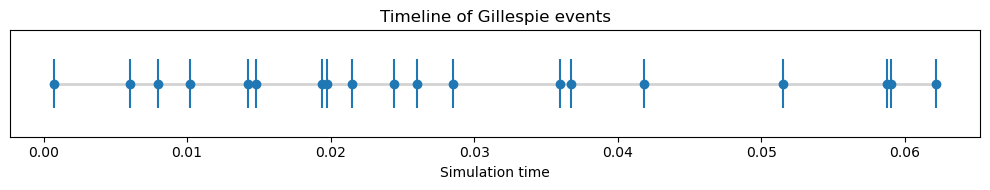

Average waiting time between events: 0.0034


In [26]:
# plot event times (like timeline, every dot represents 1 event)
plt.figure(figsize=(10, 2))
plt.hlines(1, event_times[0], event_times[-1], color='lightgray', linewidth=2)  # timeline line
plt.eventplot(event_times, lineoffsets=1, colors='tab:blue', linelengths=0.3)
plt.scatter(event_times, [1]*len(event_times), color='tab:blue', zorder=3)
plt.yticks([])
plt.xlabel("Simulation time")
plt.title("Timeline of Gillespie events")
plt.tight_layout()
plt.show()

#get avg waiting time
waiting_times = np.diff(event_times)
avg_waiting_time = np.mean(waiting_times)
print(f"Average waiting time between events: {avg_waiting_time:.4f}")

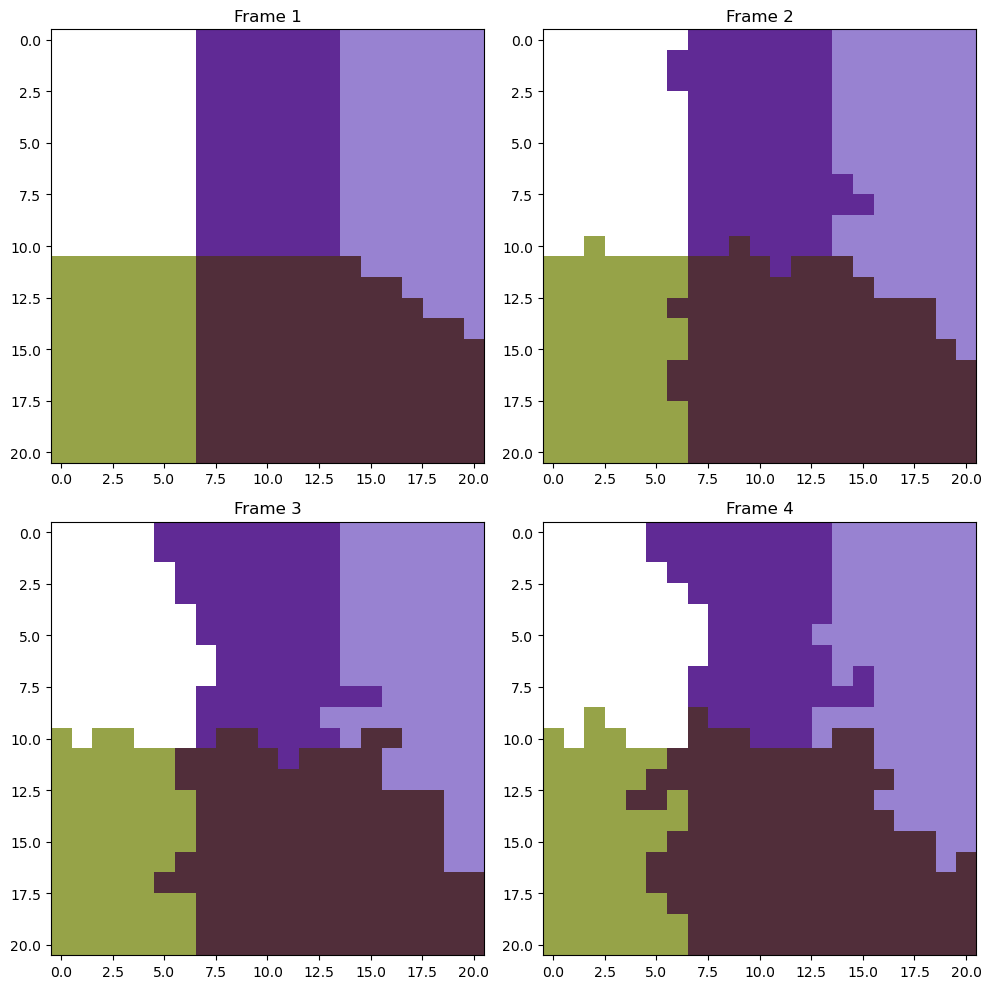

In [5]:
# Create a 2x2 plot of the first four frames
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    axes[i].imshow(frames_for_plot[i], cmap=cmap, interpolation='nearest')
    axes[i].set_title(f"Frame {i + 1}")

plt.tight_layout()
plt.show()

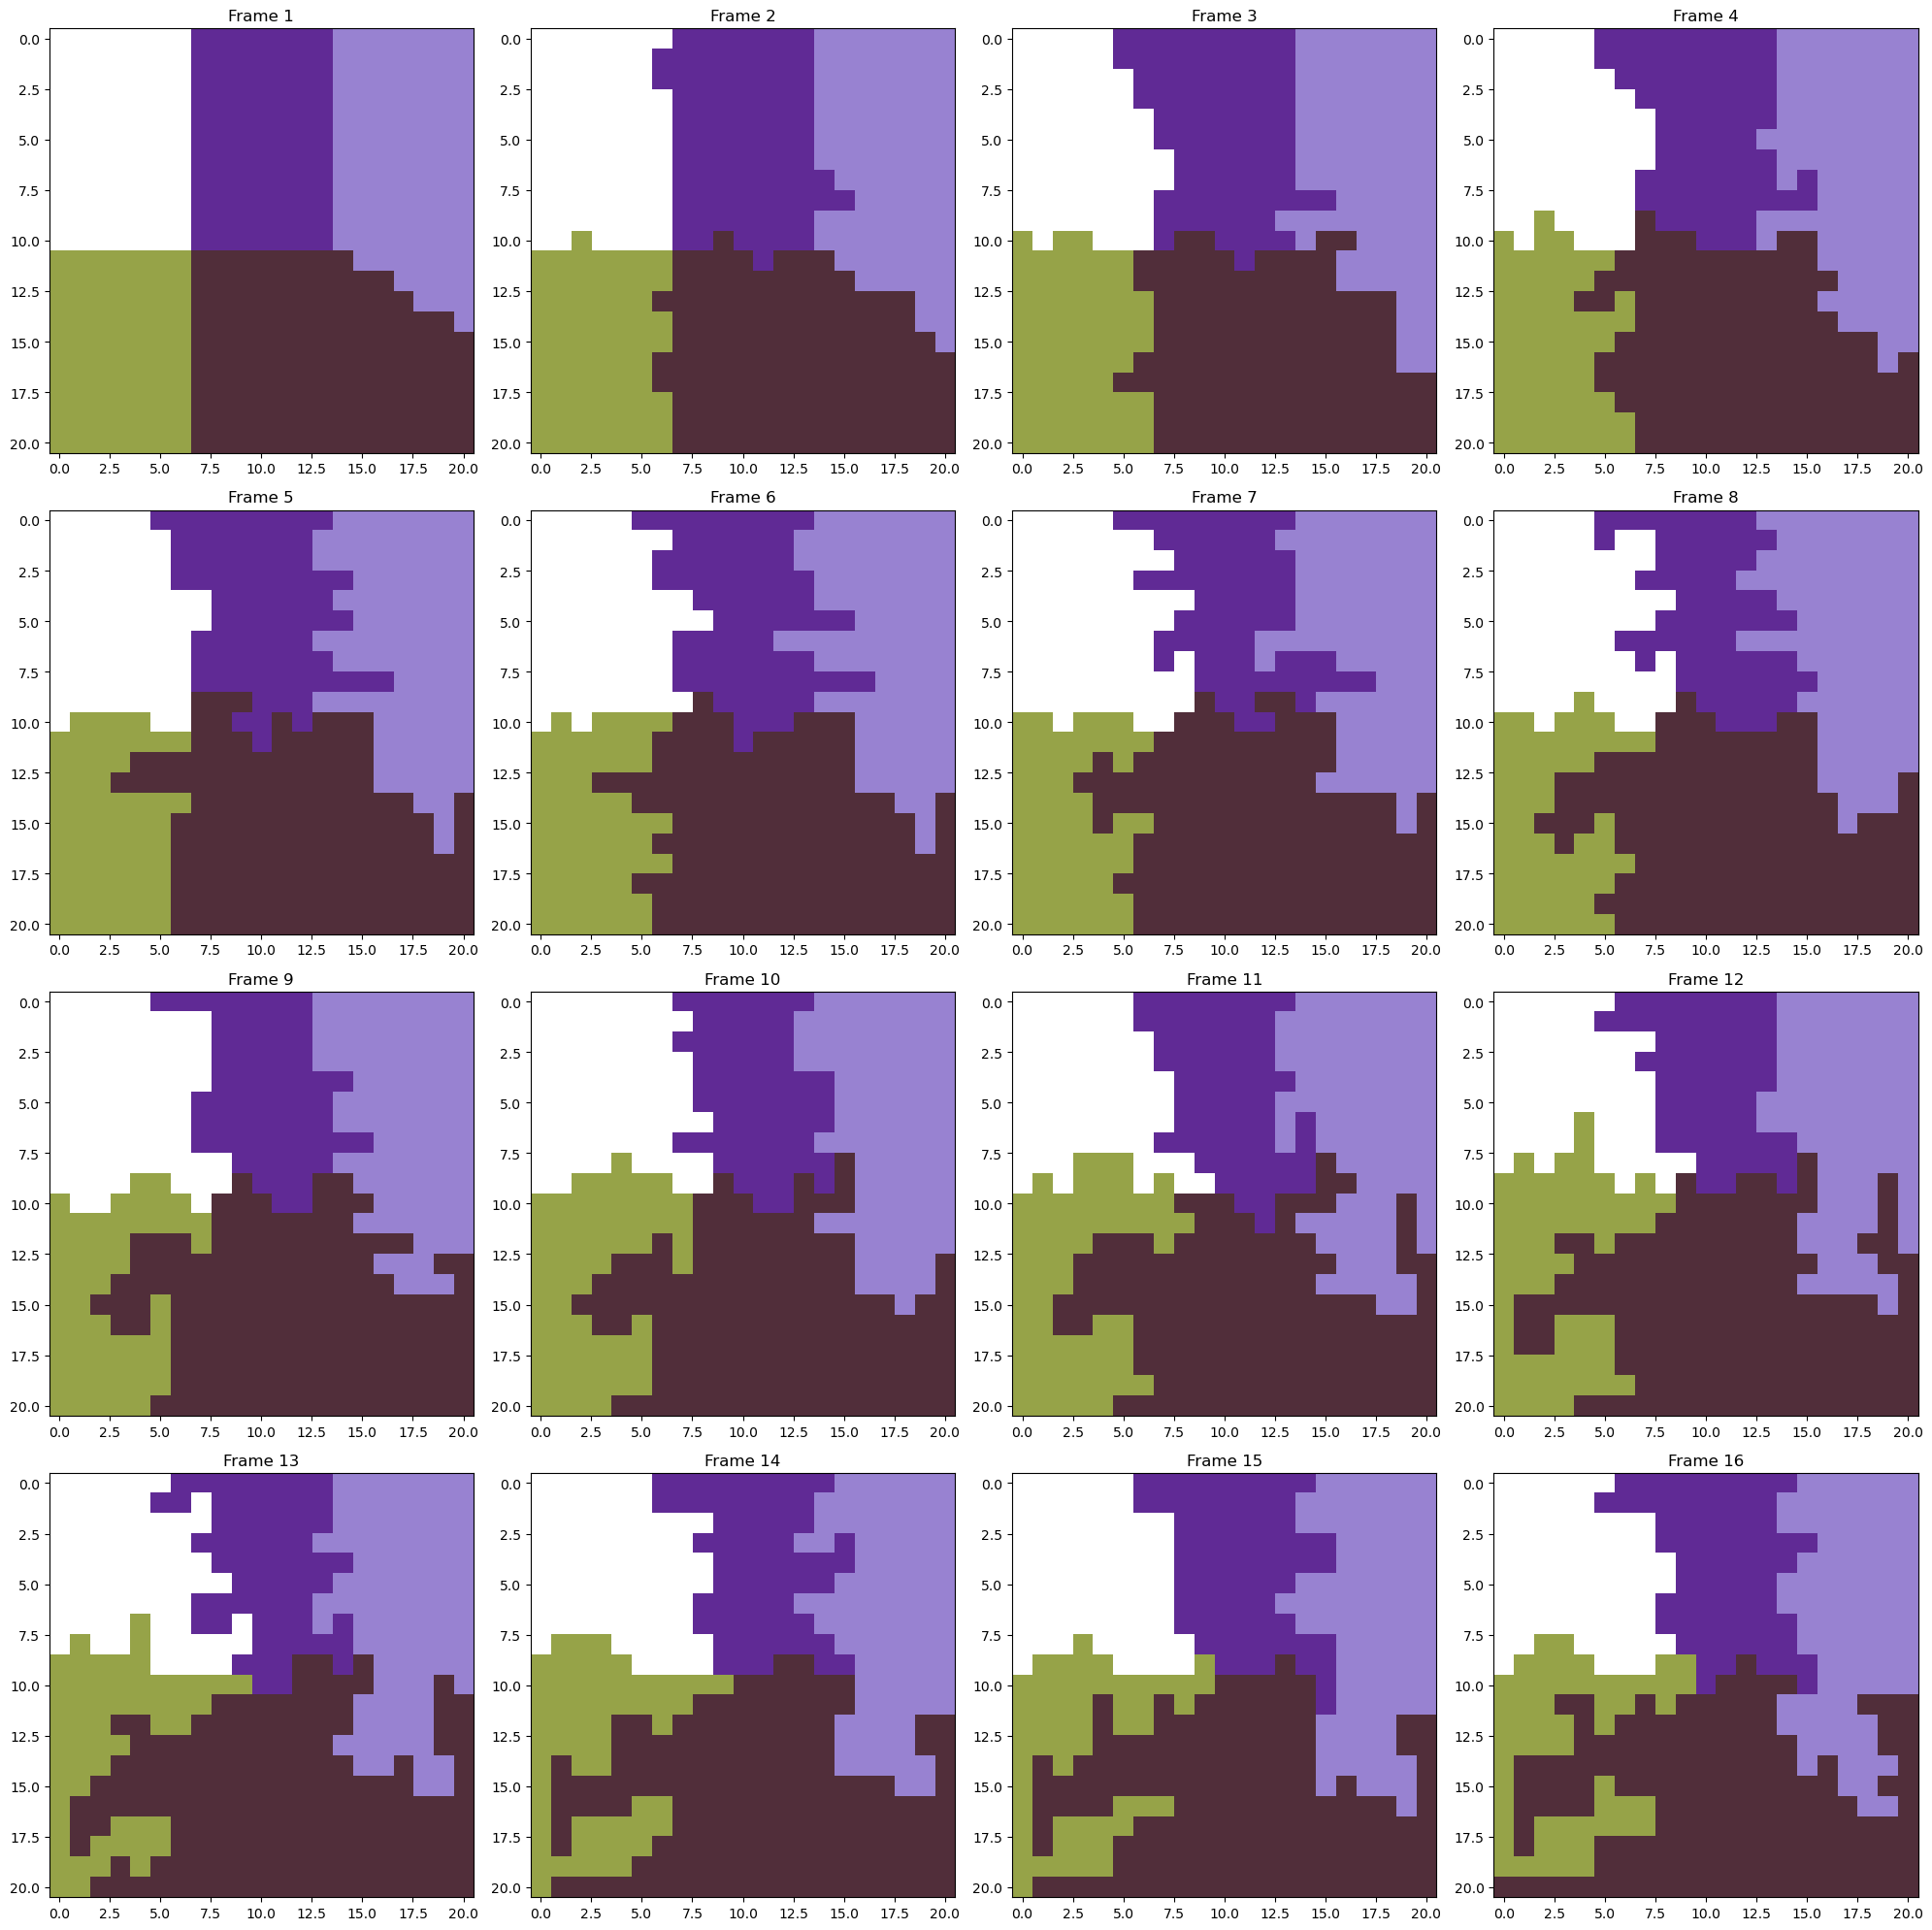

In [6]:
# Create a 5x5 plot of the first 16 frames
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i in range(16):
    axes[i].imshow(frames_for_plot[i], cmap=cmap, interpolation='nearest')
    axes[i].set_title(f"Frame {i + 1}")

plt.tight_layout()
plt.show()